In [1]:
import cmdstanpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

# Fitting a simple spline 

Here we construct a simple dataset of x vs y vs uncertainties that we fit by a cubic spline.


In [2]:
# Create the data 
rng=np.random.default_rng(22)
N = 100
x = rng.uniform(0, 1, size=N)
y0 = 1 + x + 4 * x**2 + np.sin(x * 3) * 3
ey = x * 0 + 0.3
y = y0 + rng.normal(size=N) * ey

<ErrorbarContainer object of 3 artists>

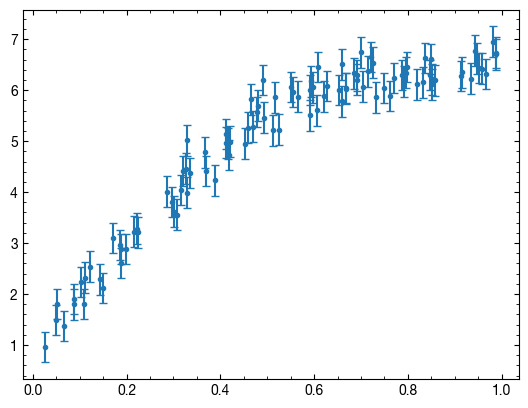

In [3]:
plt.errorbar(x,y,ey,fmt='.')

In [4]:
# Define the knots
xknots = np.array([0, 0.2, 0.4, 0.7, .9, 1])
nknots = len(xknots)

In [5]:
# contents of our stan model
!cat example.stan

functions
{
#include ../stan/spline.stan
}
data{
  int N;
  int nknots;
  vector[N] x;
  vector[N] y;
  vector[N] ey;
  vector[nknots] xknots;
}
transformed data
{
  // determine which knots the point belong to
  array[N] int x_pos_knots = spline_findpos(xknots, x);
}
parameters
{
  // the parameters of our spline model are
  // the values at the knots
  vector[nknots] yknots;
}
transformed parameters
{
  vector[nknots] spl_coeffs = spline_getcoeffs(xknots, yknots);
  // these are the spline coefficients corresponding to the current model
}

model
{
  vector[N] ymod;
  ymod = spline_eval(xknots,
		     yknots, spl_coeffs, x, x_pos_knots);
  y ~ normal (ymod, ey);
}


In [6]:
M = cmdstanpy.CmdStanModel(stan_file='example.stan')
data = {'N': N, 'x': x, 'y': y, 'ey': ey, 'xknots': xknots, 'nknots': nknots}
R = M.sample(data=data, seed=434)
res = R.stan_variables()

14:35:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:35:31 - cmdstanpy - INFO - CmdStan done processing.


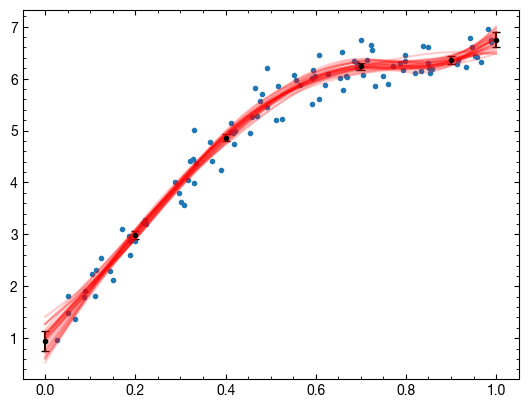

In [7]:
plt.plot(x, y, '.')
nplot = 30
xgrid = np.linspace(0, 1, 1000)
plt.errorbar(xknots,
             res['yknots'].mean(axis=0),
             res['yknots'].std(axis=0),
             fmt='.',
             color='black')
for i in range(nplot):
    C = scipy.interpolate.CubicSpline(xknots,
                                      res['yknots'][i],
                                      bc_type='natural')
    plt.plot(xgrid, C(xgrid), alpha=0.2, color='red')


# Periodic spline

Here we construct an example periodic dataset and fit it by a periodic spline

<ErrorbarContainer object of 3 artists>

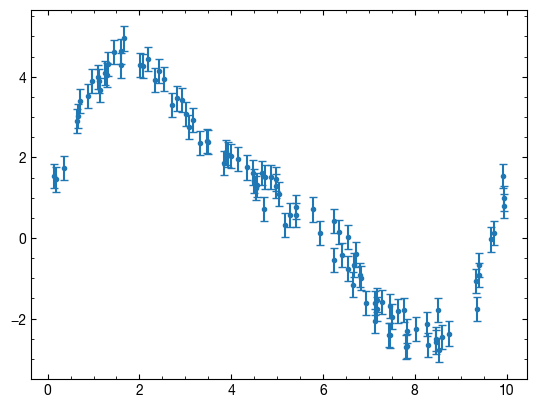

In [8]:
# Create the data 
rng=np.random.default_rng(23)

N = 100
x = rng.uniform(0, 10, size=N)
y0 = 1 + np.sin(2*np.pi/10*x)*3+ np.sin(4*np.pi/10*x)
ey = x * 0 + 0.3
y = y0 + rng.normal(size=N) * ey

plt.errorbar(x,y,ey,fmt='.')

In [9]:
M = cmdstanpy.CmdStanModel(stan_file='example_periodic.stan')
# Define the knots
xknots = np.linspace(0,10,6)
nknots = len(xknots)
data = {'N': N, 'x': x, 'y': y, 'ey': ey, 'xknots': xknots, 'nknots': nknots}
R = M.sample(data=data, seed=434)
res = R.stan_variables()

14:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:35:32 - cmdstanpy - INFO - CmdStan done processing.


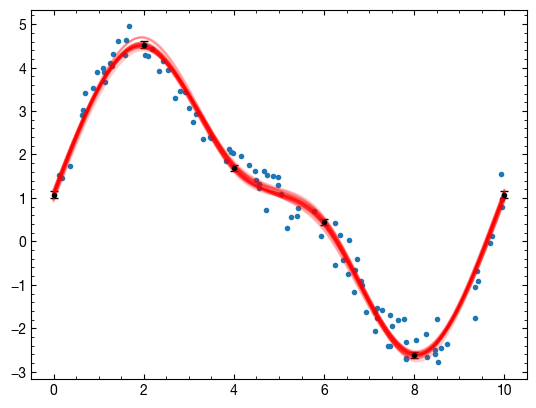

In [10]:
plt.plot(x, y, '.')
nplot = 30
xgrid = np.linspace(0, 10, 1000)
means = res['yknots'].mean(axis=0)
stds = res['yknots'].std(axis=0)
means = np.concatenate((means,[means[0]]))
stds = np.concatenate((stds,[stds[0]]))
plt.errorbar(xknots,means,stds,
             fmt='.',
             color='black')
for i in range(nplot):
    C = scipy.interpolate.CubicSpline(xknots,
                                      np.concatenate(
                                          (res['yknots'][i],[res['yknots'][i][0]])),
                                      bc_type='periodic')
    plt.plot(xgrid, C(xgrid), alpha=0.2, color='red')